В этом проекте необходимо было: 
- скачать датасет от Гугла с мультяшными персонажами. Ссылка: https://storage.googleapis.com/datasets_ai/Advanced/1_VAE/cartoonset10k.zip
- обучить VAE на данном датасете
- посмотреть качество воспроизведения мультяшек
- нагенерить мультяшек на свой вкус - оцените работу декодера

При подготовке данного проекта отработано ОГРОМНОЕ количество гипотез.

Сам датасет состоит из изображений, к каждому из которых приложен csv файл с описанием различных признаков. Поскольку характеристик изображений было очень много, мною принято решение в качестве правильных ответов взять информацию о цвете волос персонажа (всего 10 вариантов).

В итоге удалось найти оптимальный набор количественных параметров и структуры НС, при которой при генерации случайных точек, сеть выдает изображение мультяшки.

Также, если смотреть на точки в скрытом пространстве (график в конце проекта), то можно заметить, что мы получили более компактное использование скрытого пространства, которое стало практически непрерывным.

In [1]:
# Подключим Numpy
import numpy as np
import pandas as pd

# Подключим библиотеку отображения графиков
import matplotlib.pyplot as plt

# Импортируем Keras
from tensorflow import keras

import tensorflow as tf
import tensorflow_datasets as tfds

# Подключим все необходимые слои Keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate, Conv2D, Conv2DTranspose

# Подключим модуль вычислений на Keras
import keras.backend as K

# Загрузка датасетов из облака google
import gdown

# Подключим модуль работы с операционной системой
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # От tensorflow будет получать только ошибки

from PIL import *

from google.colab import files

from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from sklearn.model_selection import train_test_split

# очистка ОЗУ
import gc 

In [2]:
# Загрузка датасета из облака
gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/1_VAE/cartoonset10k.zip', None, quiet=True)

'cartoonset10k.zip'

In [3]:
# Распаковка архива в папку cartoonset10k
!unzip -qo cartoonset10k.zip -d cartoonset10k/

# Просмотр содержимого папки
#!ls cartoonset10k

In [4]:
# Путь к директории с базой
base_dir = '/content/cartoonset10k'

In [5]:
path = '/content/cartoonset10k/cs10000053986926948907.png'

img = Image.open(path)
print(img.size)

(500, 500)


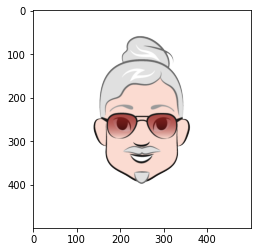

In [6]:
# посмотрим на изображение из датасета
plt.imshow(img)

In [7]:
path_csv='/content/cartoonset10k/cs10303524432705001174.csv'

In [8]:
# в нашем датасете есть как изображения, так и csv файлы. Посмотрим, что там:
xyz = pd.read_csv(path_csv, header=None)

In [9]:
xyz

,0,1,2
0,eye_angle,2,3
1,eye_lashes,1,2
2,eye_lid,0,2
3,chin_length,0,3
4,eyebrow_weight,0,2
5,eyebrow_shape,2,14
6,eyebrow_thickness,1,4
7,face_shape,2,7
8,facial_hair,12,15
9,hair,54,111


В данном датасете к каждому изображению идет отдельное описание. Для нашего задания таблички пригодятся для того, чтобы получить правильные ответы о принадлежности картинки к какой-то группе. 

В датасете картинки характеризуются следующим набором характеристик:


# Variants	Description
Artwork
chin_length	3	
eye_angle	3	
eye_lashes	2	
eye_lid	2	
eyebrow_shape	14	
eyebrow_weight	2	
face_shape	7	
facial_hair	15	
glasses	12	
hair	111	
 
Colors
eye_color	5	
face_color	11	
glasses_color	7	
hair_color	10	
 
Proportions
eye_eyebrow_distance	3	
eye_slant	3	
eyebrow_thickness	4	
eyebrow_width	3	

Так как вариантов очень много, было принято решение остановиться на одной характеристике - цвет волос персонажа (всего 10 вариантов)

Создадим выборку, состоящую из изображений (расширение png).

In [10]:
img_height, img_width = 256, 256

In [11]:
image_list = []
for file in os.listdir(base_dir):
  extension = ".png"
  if os.path.splitext(file)[1] in extension:
      image_list.append((np.array(image.load_img(base_dir + '/' + file, target_size=(256, 256), color_mode='grayscale'))))

In [12]:
gc.collect()

98

In [13]:
gc.collect()

50

In [14]:
x_train = np.array(image_list)

In [15]:
x_train1 = x_train.reshape(x_train.shape[0], 256, 256, 1)

In [16]:
# Проверка результата
print(f'Форма обучающих данных: {x_train.shape}')

Форма обучающих данных: (10000, 256, 256)


In [17]:
X_train2 = x_train1.astype('float32') / 255.

In [18]:
X_train2[0].shape

(256, 256, 1)

In [19]:
# поделим датасет на тренировочную и тестовую выборки
#X_train, X_test = train_test_split(X_train2, test_size=0.6, random_state=42)
X_train=X_train2[:6000]
X_test=X_train2[6000:]

In [20]:
X_train=np.array(X_train)
X_test=np.array(X_test)

In [21]:
print(X_train.shape)
print(X_test.shape)

(6000, 256, 256, 1)
(4000, 256, 256, 1)


In [22]:
# так как в имеющемся описании к изображениям категорий слишком много, возьмем 1 - цвет волос. Сделаем список с правильными ответами на основании цвета волос на картинке
y_all=[]
for file in os.listdir(base_dir):
  extension = ".csv"
  if os.path.splitext(file)[1] in extension:
    path_csv='/content/cartoonset10k/' +file
    ind=pd.read_csv(path_csv, header=None).iloc[12, 1]
    y_all.append(ind)

In [23]:
Y_train=y_all[:6000]
Y_test=y_all[6000:]
print(len(Y_train))
print(len(Y_test))

6000
4000


In [24]:
# Проверим версию. Работаем на 2х версии
#tf.version

In [25]:
# Импортируем Keras
import keras

# Импортируем Keras
from tensorflow import keras

# Проверим версию - 2.7.0 актуальная
keras.__version__

'2.7.0'

In [26]:

gc.collect()

200

In [27]:
hidden_dim = 200  # Зададим размерность скрытого пространства AE

#batch_size = 128 # Задамим размер батча для обучения AE(должно быть кратно 10 000)

In [28]:
# Создадим функцию сборки блока построения сверточного энкодера

def encoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейроной сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1): # Число шагом сверточного слоя

    # Составим блок сети
    x = Conv2D(neu, kernel_size=kernel, strides= strides, padding='same')(xin) # Добавим 2D свертку
    x = BatchNormalization()(x)                                                # Добавим нормализацию по батчу
    x = LeakyReLU()(x)                                                         # Добавим функцию активации

    # Вернем выходной тензор
    return x


In [29]:
# Создадим функцию сборки блока построения сверточного декодера

def decoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейроной сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1): # Число шагом сверточного слоя

    # Составим блок сети
    x = Conv2DTranspose(neu, kernel_size=kernel, strides= strides, padding='same')(xin)  # Добавим обратную 2D свертку
    x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
    x = LeakyReLU()(x)                                                                   # Добавим функцию активации

    # Вернем выходной тензор
    return x

In [30]:
# Функция создания блока энкодера-декодера

def dropout_and_batch(xin): # xin - входной тензор

  x = BatchNormalization()(xin) # Добавим слой нормализации
  x = Dropout(0.3)(x)           # Добавим дроаут
  
  # Вернем выходной тензор
  return x     

In [31]:
# Создадим сверточный энкодер

input_img = Input(shape=(256, 256, 1))                     # Добавим входной слой
x = encoderBlock(input_img, neu=8, kernel=3, strides=1) # Добавим 1-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=8, kernel=3, strides=2)         # Добавим 2-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=8, kernel=3, strides=2)         # Добавим 3-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=16, kernel=3, strides=2)         # Добавим 4-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=16, kernel=3, strides=2)
x = encoderBlock(x, neu=32, kernel=3, strides=2)

flatten =Flatten()(x)                                    # Добавим Flatten
x = Dense(200, activation='linear')(flatten)               # Добавим выходной dense слой

Выход энкодера подаем сразу, параллельно на два dense-слоя – формирователи мат. ожидания и логарифма дисперсии. Здесь вместо точки в пространстве Z формируется облачко:

In [32]:
z_mean = Dense(hidden_dim)(x)        # Добавим dense для получения мат.ожидания
z_log_var = Dense(hidden_dim)(x)     # Добавим dense для получения логарифма дисперсии

In [33]:
# Создадим функцию - генератор случайных чисел с заданными параметрами

def noiser(args):                                                         # Входные параметры
  z_mean, z_log_var = args                                                # Разберем входные параметры на отдельные переменные
  N = K.random_normal(shape=(K.shape(z_mean)[0], hidden_dim), mean=0., stddev=1.0)# Генерируем тензор из нормальных случайных  чисел с параметрами (0,1)

  # Вернем тензор случайных числел с заданной дисперсией и мат.ожиданием
  return K.exp(z_log_var / 2) * N + z_mean                                 

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])       # Создадим свой слой - лямбда. На входе мат.ожидание и логарифм дисперсии 
                                                                          # На выходе - тензор случайных чисел 

In [34]:
 # Соберем энкодер

encoderVAEС = keras.Model(input_img, [z_mean, z_log_var, h], name='encoder')

In [35]:
# Создадим сверточный декодер

input_enc = Input(shape=(200,))                            # Добавим входной слой
x = Dense(4096, name='dense_1')(input_enc)               # Добавим dense в 7х7х64 = 3136 нейронами
x = Reshape((8, 8, 64))(x)                               # Решейпим 1D тензор в 3D тензор
x= decoderBlock(x, neu=32, kernel=3, strides=1)          # Добавим 1-й блок обратная свертка+нормализация+активашка
x= decoderBlock(x, neu=16, kernel=3, strides=2)          # Добавим 2-й блок обратная свертка+нормализация+активашка
x= decoderBlock(x, neu=16, kernel=3, strides=2)          # Добавим 3-й блок обратная свертка+нормализация+активашка
#x= Conv2D(32, kernel_size=3)(x)
x= decoderBlock(x, neu=16, kernel=3, strides=2)
x= decoderBlock(x, neu=8, kernel=3, strides=2)
x= decoderBlock(x, neu=8, kernel=3, strides=2)

decoded = Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)# Добавим выходной слой

In [36]:
# Соберем декодер

decoderVAEС = keras.Model(input_enc, decoded, name='decoder')    

In [37]:
# Запишем выражение для декодера, заметим, что за вход декодера подается только 1 их выходов энкодера

outputs = decoderVAEС(encoderVAEС(input_img)[2]) 

In [38]:
# Соберем наши сетки

vaec = keras.Model(input_img, decoderVAEС(encoderVAEС(input_img)[2])) # Соберем VAE

In [39]:
reconstruction_loss = keras.losses.MSE(input_img, outputs)     # Рассчитаем ошибку восстановления изображения - лоссы MSE
reconstruction_loss *= 256*256                                   # Уберем нормировку MSE
#reconstruction_loss *= 1000
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  # Рассчитаем лоссы KL
kl_loss = -0.5* K.sum(kl_loss, axis=-1)                        #  
vaeс_loss = K.mean(reconstruction_loss) +  K.mean(kl_loss)      # Суммируем лоссы - здесь можно вводить веса  
vaec.add_loss(vaeс_loss)                                         # Отдадим наш лосс VAE

In [40]:
# Выведем состав энкодера
#encoderVAEС.summary()

In [41]:
#  Выведем состав энкодера
#decoderVAEС.summary()

In [42]:
#tf.keras.utils.plot_model(decoderVAEС, show_shapes=True, dpi=50)

In [43]:
# Компилируем VAE
opt = keras.optimizers.Adam(learning_rate=0.001)
vaec.compile(optimizer=opt) # оптимайзер ADAM

In [44]:
gc.collect()

1941

In [45]:
X_train.shape

(6000, 256, 256, 1)

In [46]:
# Запускаем обучениe

vaec.fit(X_train,      # Обучающая выборка
        X_train,       # "Labels" обучающей выборки
        epochs=40,      # 10 эпох
        batch_size=8 # размер батча
        )  # обучающую выборку перемешиваем

Epoch 1/40
750/750 [==============================] - 64s 67ms/step - loss: 1186.6792
Epoch 2/40
750/750 [==============================] - 50s 67ms/step - loss: 680.6089
Epoch 3/40
750/750 [==============================] - 50s 66ms/step - loss: 595.2426
Epoch 4/40
750/750 [==============================] - 50s 66ms/step - loss: 555.9611
Epoch 5/40
750/750 [==============================] - 50s 66ms/step - loss: 519.1519
Epoch 6/40
750/750 [==============================] - 50s 66ms/step - loss: 492.9791
Epoch 7/40
750/750 [==============================] - 50s 67ms/step - loss: 472.0309
Epoch 8/40
750/750 [==============================] - 50s 67ms/step - loss: 456.3635
Epoch 9/40
750/750 [==============================] - 50s 66ms/step - loss: 444.0211
Epoch 10/40
750/750 [==============================] - 50s 67ms/step - loss: 427.3513
Epoch 11/40
750/750 [==============================] - 50s 67ms/step - loss: 422.7693
Epoch 12/40
750/750 [==============================] - 50s 67m

In [47]:
#Пересохранение обученной модели полностью (веса и архитектура)
#vaec.save('model_vaec1')

In [48]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [49]:
# сохраним модель на гугл драйв:
#path = F"/content/gdrive/My Drive/models" 
#vaec.save(path+'/model_vaec')

In [50]:
# проверим, действительно ли она там сохранился:
#!ls '/content/gdrive/My Drive/models'

In [51]:
# сохраним путь до модели
#model_path='/content/gdrive/MyDrive/models/model_vaec'

In [52]:
gc.collect()

795

In [53]:
#from tensorflow.keras.models import load_model
#model = load_model(model_path)                    # Загрузка модели

In [54]:
len(X_test)

4000

In [55]:
len(Y_test)

4000

In [56]:
batch_size=100
hidden_dim=200
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки
generator=decoderVAEС

In [57]:
vec3=np.random.normal(size = (1,hidden_dim))

In [58]:
img = decoderVAEС.predict(vec3)

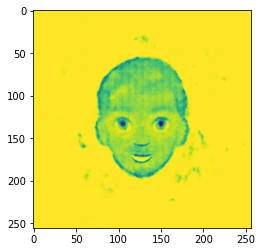

In [59]:
plt.imshow(img.squeeze())

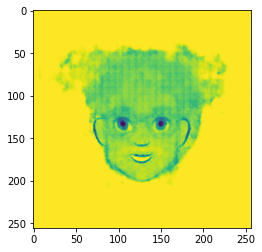

In [60]:
vec2=np.random.normal(size = (1,hidden_dim))
img2 = decoderVAEС.predict(vec2)
plt.imshow(img2.squeeze())

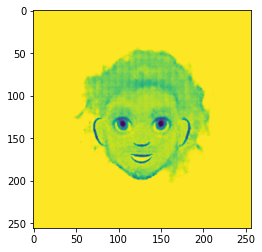

In [65]:
vec1=np.random.normal(size = (1,hidden_dim))
img1 = decoderVAEС.predict(vec1)
plt.imshow(img1.squeeze())

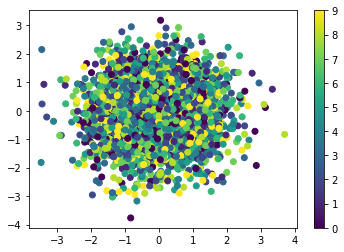

In [62]:
h = encoderVAEС.predict(X_test[:5500], batch_size=batch_size)    # Предиктим энкодером первые 6000 цизображений ифр 
plt.scatter(h[2][:, 0], h[2][:, 1] , c=Y_test[:5500], cmap='viridis') # Выводим  скаттер координат точек скрытого пространства
plt.colorbar()                                                  # Выводим цветовую шкалу - каждому классу свой цвет
plt.show()           

Выводы: на мой взгляд, удалось достичь целей, поставленных в данном задании. На графике видно, что точки представляют собой практически непрерывное пространство, при попытке генерации изображений удается получить различимые картинки в любой рандомной точке.